In [1]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
import pandas_ta as ta

from performance_indicator import *
from trading_computation import *
from plotting_computation import *

In [2]:
LEVERAGE = 10
MAX_LEVERAGE = 10
INITIAL_CAP = 200000
TRAINSIZE = 0.7
INCREASE_RF = False # Explore the situation when effr increase 150%

## 1. Time Series Prep

- The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [3]:
end_date = datetime(2019, 12, 31)
start_date = datetime(2014, 1, 1)

# Download data as dataframe
ETF = yf.download('SPTL', start=start_date, end=end_date).reset_index()
EFFR = web.DataReader('EFFR', 'fred', start_date, end_date).dropna().reset_index().rename({'DATE':'Date'}, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [4]:
# The EFFR data will be Nan at weekends or some other federal holidays
# The weekends are not tradings days and hence they are dropped. Otherwise, use forward fill method
# Assuing the EFFR data to the same as the previous day
df = pd.merge(left = ETF, right = EFFR, on = 'Date', how = 'left').ffill(axis = 0)
df = df[['Date', 'Close', 'EFFR']]
df['EFFR'] = pd.to_numeric(df['EFFR'], errors='coerce')
# Adjust the annual risk-free rate to make it a daily rate
if INCREASE_RF:
    df['Daily_EFFR'] = df['EFFR']/(252*100) * 1.5
else:
    df['Daily_EFFR'] = df['EFFR']/(252*100)
# Calculate the daily execess return per unit SPTL
df['Daily_return'] = df['Close'].pct_change(1, fill_method='ffill')
df['Daily_excess_return'] = df['Close'].pct_change(1, fill_method='ffill') - df['Daily_EFFR']

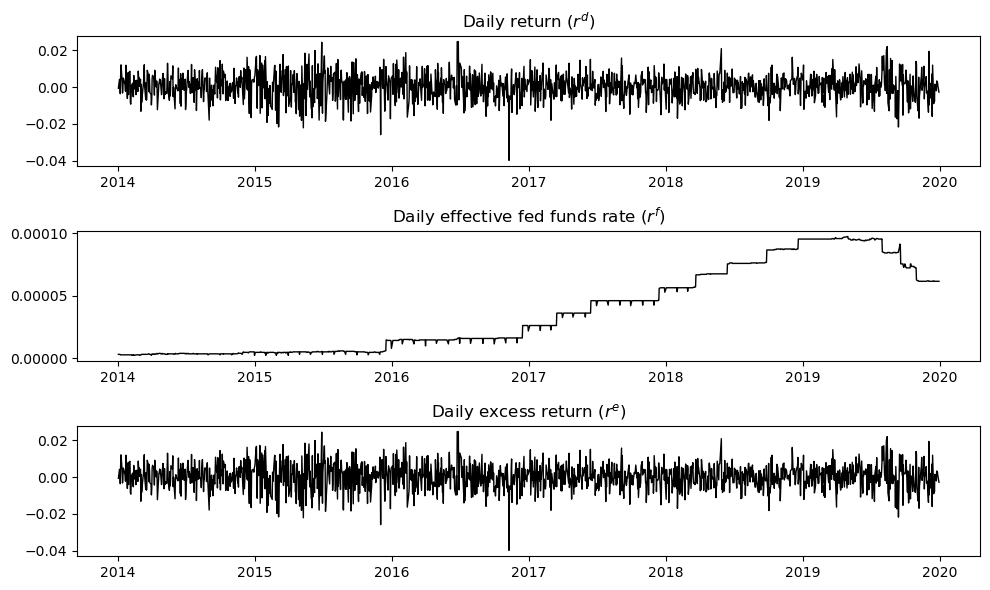

In [5]:
fig, ax = plt.subplots(3, 1, figsize = (10, 6))

ax[0].plot(df['Date'], df['Daily_return'], color = 'black', lw = 1)
ax[0].set_title(r'Daily return ($r^d$)')
ax[1].plot(df['Date'], df['Daily_EFFR'], color = 'black', lw = 1)
ax[1].set_title(r'Daily effective fed funds rate ($r^f$)')
ax[2].plot(df['Date'], df['Daily_excess_return'], color = 'black', lw = 1)
ax[2].set_title(r'Daily excess return ($r^e$)')
plt.tight_layout()

## 2. Trading Strategies

### Strategy: LSTM Strategy

In [6]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import load_model

In [7]:
data = df.copy()
# Adding indicators
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=50)

data.dropna(inplace=True)
data.reset_index(inplace = True)
dataset = data[['Close', 'RSI', 'EMAF', 'EMAM']]

In [8]:
# Create a function to create a dataset with 60 timesteps
def create_dataset(dataset, time_step=60, y_colume_index=0):
    X, Y = [], []
    if not isinstance(dataset, np.ndarray):
        dataset = np.array(dataset).reshape(len(dataset), -1)

    if len(dataset.shape) == 1:
        dataset = dataset.reshape(-1, 1)
        
    # If we have 5 days of data and we want to look back 2 days
    # x1 = [d1, d2], y1 = [d3];
    # x2 = [d2, d3], y2 = [d4]; 
    # x3 = [d3, d4], y3 = [d5];
    for i in range(len(dataset) - time_step):
        
        # Slice from index i to index i + timestep, excluding (i + time_step)
        X.append(dataset[i:(i+time_step), :])
        Y.append(dataset[i + time_step, y_colume_index])
    return np.array(X), np.array(Y)


scalar = MinMaxScaler()
scaled_dataset = scalar.fit_transform(dataset)
# Create the dataset
time_step = 6
X, y = create_dataset(dataset, time_step, y_colume_index=0)

# The shape should be, (number of sequence, number of days to look back, number of columns)
print(X.shape)
print(y.shape)


(1454, 6, 4)
(1454,)


In [9]:
# split data into train test sets
splitlimit = int(len(X) * TRAINSIZE)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

train_set = df[:splitlimit]
test_set = df[splitlimit:]
test_set

(1017, 6, 4)
(437, 6, 4)
(1017,)
(437,)


,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return
1017,2018-01-17,35.919998,1.42,0.000056,-0.001945,-0.002001
1018,2018-01-18,35.610001,1.42,0.000056,-0.008630,-0.008687
1019,2018-01-19,35.419998,1.42,0.000056,-0.005336,-0.005392
1020,2018-01-22,35.439999,1.42,0.000056,0.000565,0.000508
1021,2018-01-23,35.610001,1.42,0.000056,0.004797,0.004741
...,...,...,...,...,...,...
1504,2019-12-23,39.160000,1.55,0.000062,-0.002039,-0.002100
1505,2019-12-24,39.290001,1.55,0.000062,0.003320,0.003258
1506,2019-12-26,39.389999,1.55,0.000062,0.002545,0.002484
1507,2019-12-27,39.419998,1.55,0.000062,0.000762,0.000700


In [10]:

def train_lstm(seed):
    tf.random.set_seed(seed)
    # Build the LSTM model
    model = Sequential()
    # Return sequence: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
    # Inputs: A 3D tensor, with shape (batch, timesteps, feature).
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# model = train_lstm(seed = 10)
# model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, validation_split = 0.1)
# # model.save('models/lstm_v1.h5')

In [11]:
model = load_model('models/lstm_v1.h5')

y_pred_train = model.predict(X_train)
rmse = np.sqrt(np.mean((y_pred_train - y_train)**2))
print(f"Training Set -> Root Mean Squared Error: {rmse}")

y_pred_test = model.predict(X_test)
# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print(f"Testing Set -> Root Mean Squared Error: {rmse}")

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-03-16 19:18:35.579401: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-16 19:18:35.579672: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-03-16 19:18:36.175005: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-16 19:18:36.424200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-16 19:18:36.498847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/32 [========>.....................] - ETA: 0s 

2024-03-16 19:18:36.625210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 9ms/step
Training Set -> Root Mean Squared Error: 2.6087509657746
14/14 [==============================] - 0s 11ms/step
Testing Set -> Root Mean Squared Error: 3.570539551592368


In [12]:
def buy_sell_threshold(current_price, predicted_price, threshold):
    # The backtest framework skips the first iteration
    Buy, Sell = [0], [0]

    for i in range(len(predicted_price)-1):
        if predicted_price[i] / current_price[i] - 1 > threshold:
            Buy.append(current_price[i])
            Sell.append(0)
        elif predicted_price[i] / current_price[i] - 1 < - threshold:
            Sell.append(current_price[i])
            Buy.append(0)
        else:
            Buy.append(0)
            Sell.append(0)
    return Buy, Sell

def generate_dynamic_signals(current_price, predictions, threshold=0.01):
    # Assuming predictions are normalized and centered around 0
    signals = np.zeros(len(predictions))

    for i in range(1, len(predictions)):
        change_percent = (predictions[i] / current_price[i] * 100) -1

        # if change_percent > threshold:
        if abs(change_percent) > threshold:
            # Signal strength is proportional to the change percent
            signals[i] = np.tanh(change_percent)
        else:
            signals[i] = 0
    
    return signals


In [13]:
strategy_data = pd.DataFrame(index=data.index)
strategy_data['Close'] = data['Close']
strategy_data['Date'] = data['Date']
strategy_data['Predictions'] = np.nan
strategy_data['Daily_EFFR'] = data['Daily_EFFR']
strategy_data['Daily_excess_return'] = data['Daily_excess_return'] 

strategy_data.iloc[time_step: time_step+len(y_pred_train), strategy_data.columns.get_loc('Predictions')] = y_pred_train.flatten()
strategy_data.iloc[len(X_train)+time_step:len(X_train)+time_step+len(y_pred_test),strategy_data.columns.get_loc('Predictions')] = y_pred_test.flatten()


In [14]:
strategy_data['Buy_Signal_Price'], strategy_data['Sell_Signal_Price'] = buy_sell_threshold(current_price = strategy_data['Close'], 
                                                                                           predicted_price = strategy_data['Predictions'], 
                                                                                           threshold = 0.02)
buy_signal = np.where(strategy_data['Buy_Signal_Price'] > 0, 1, 0)
sell_signal = np.where(strategy_data['Sell_Signal_Price'] > 0, -1, 0)
signal = buy_signal + sell_signal
strategy_data['Signal'] = signal
strategy_data

,Close,Date,Predictions,Daily_EFFR,Daily_excess_return,Buy_Signal_Price,Sell_Signal_Price,Signal
0,31.805000,2014-03-14,NaN,0.000003,0.000311,0.0,0.0,0
1,31.590000,2014-03-17,NaN,0.000003,-0.006763,0.0,0.0,0
2,31.665001,2014-03-18,NaN,0.000003,0.002371,0.0,0.0,0
3,31.440001,2014-03-19,NaN,0.000003,-0.007109,0.0,0.0,0
4,31.379999,2014-03-20,NaN,0.000003,-0.001912,0.0,0.0,0
...,...,...,...,...,...,...,...,...
1455,39.160000,2019-12-23,39.528004,0.000062,-0.002100,0.0,0.0,0
1456,39.290001,2019-12-24,39.448524,0.000062,0.003258,0.0,0.0,0
1457,39.389999,2019-12-26,39.562721,0.000062,0.002484,0.0,0.0,0
1458,39.419998,2019-12-27,39.637436,0.000062,0.000700,0.0,0.0,0


(31.0, 43.0)

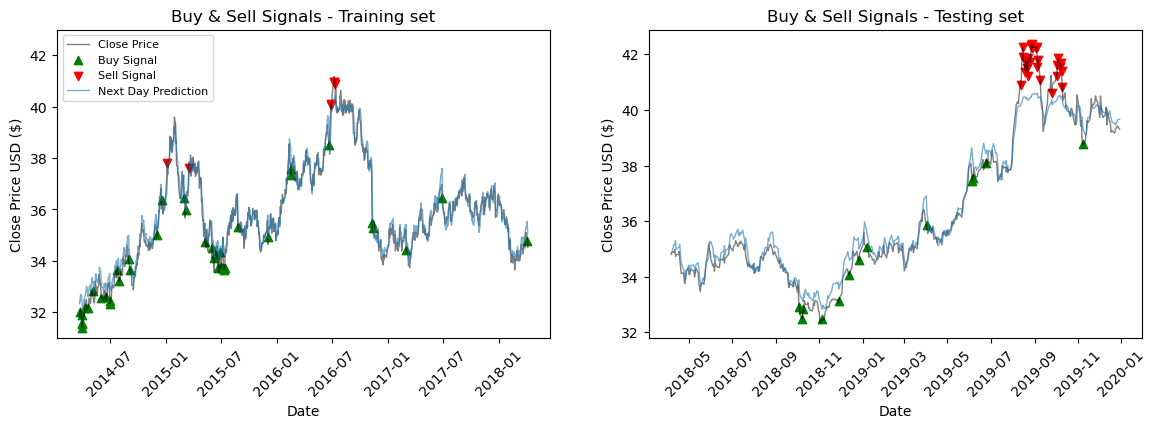

In [15]:
train_set = strategy_data.iloc[time_step: time_step+len(y_pred_train)]
test_set = strategy_data.iloc[len(X_train)+time_step:len(X_train)+time_step+len(y_pred_test)]
fig, ax = plot_signals_compare(train_data = train_set, 
                     train_signal = train_set['Signal'], 
                     test_data = test_set, 
                     test_signal = test_set['Signal'])
ax[0].legend(loc = 'upper left', fontsize = 8)

ax[0].plot(train_set['Date'], y_pred_train, lw = 1, alpha = 0.6, label = 'Next Day Prediction')
ax[0].tick_params(axis = 'x', labelrotation=45)
ax[0].legend(loc = 'upper left')

ax[1].plot(test_set['Date'], y_pred_test, lw = 1, alpha = 0.6, label = 'Next Day Prediction')
ax[1].tick_params(axis = 'x', labelrotation=45)
ax[0].legend(loc = 'upper left', fontsize = 8)
ax[0].set_ylim(31, 43)


/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


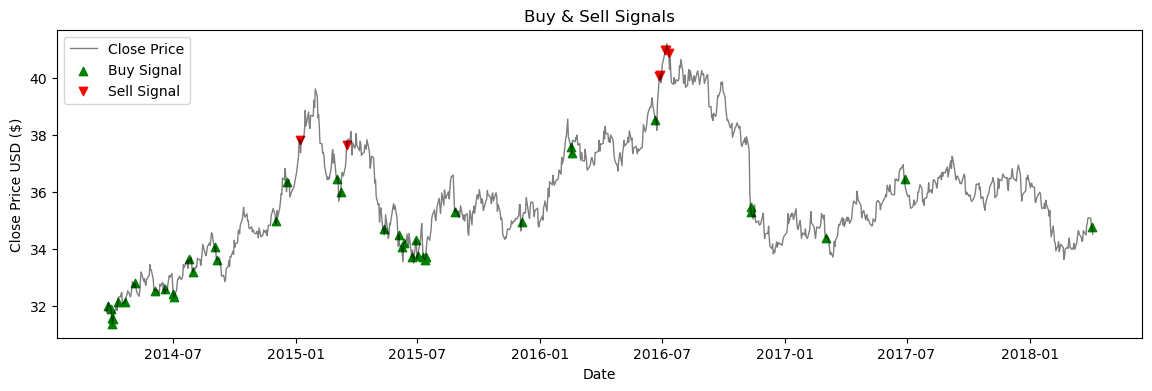

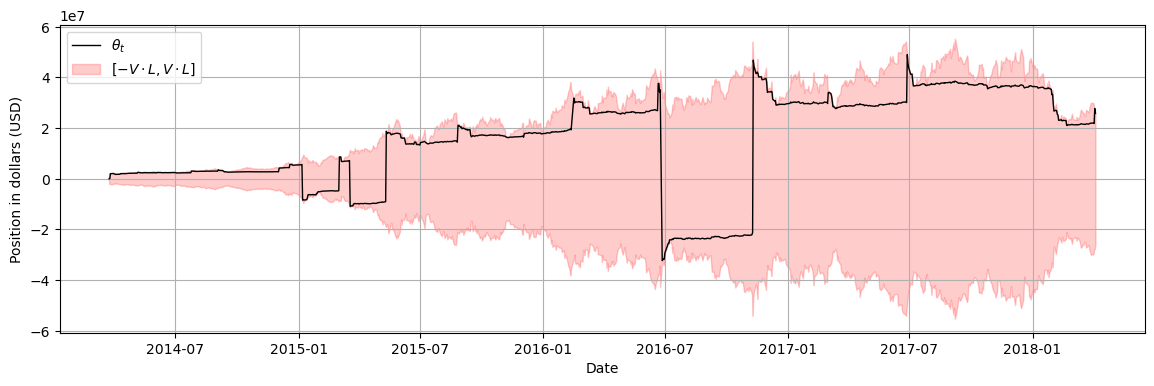

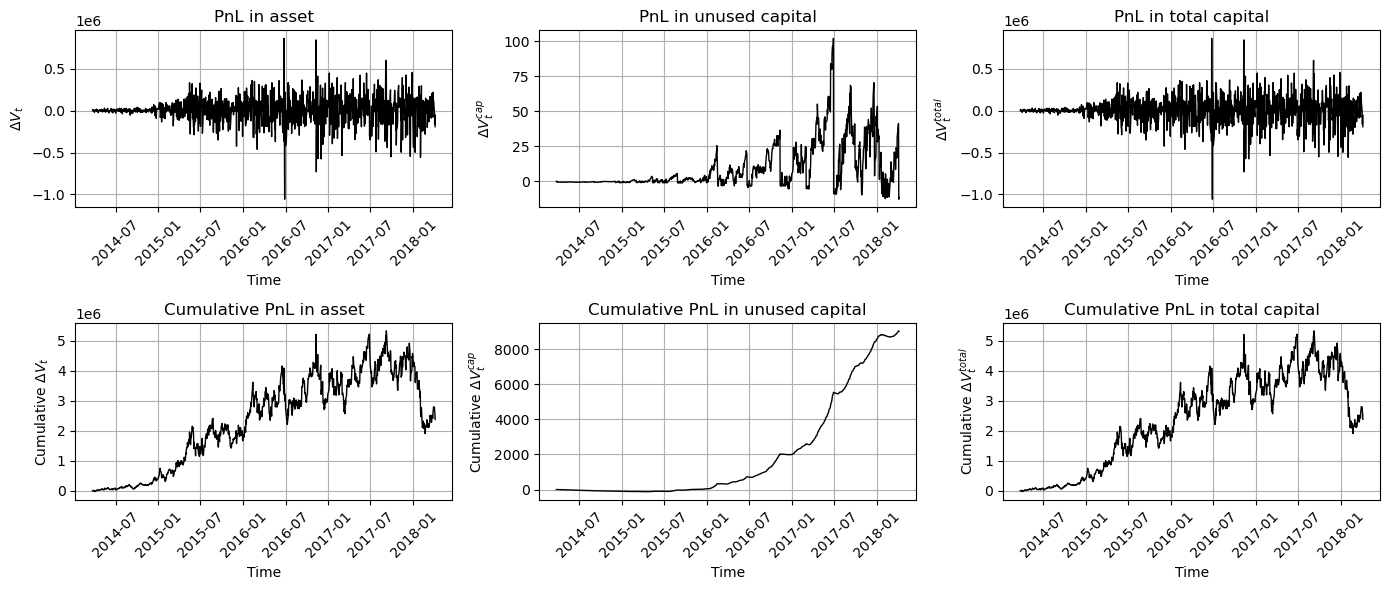

In [16]:
result_train = compute_position_value(df = train_set, 
                           signal = train_set['Signal'], 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0 = True)

plot_strategy(df = train_set, 
              result_dict = result_train, 
              signal = train_set['Signal'], 
              leverage = MAX_LEVERAGE)

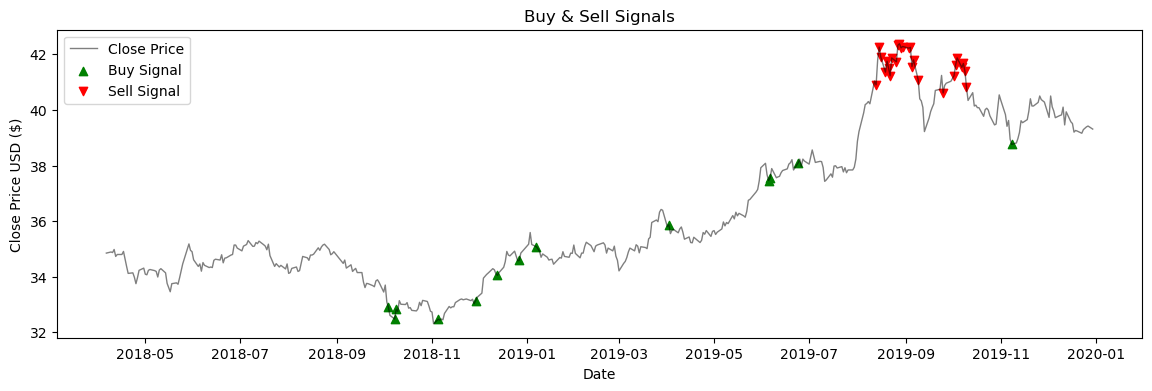

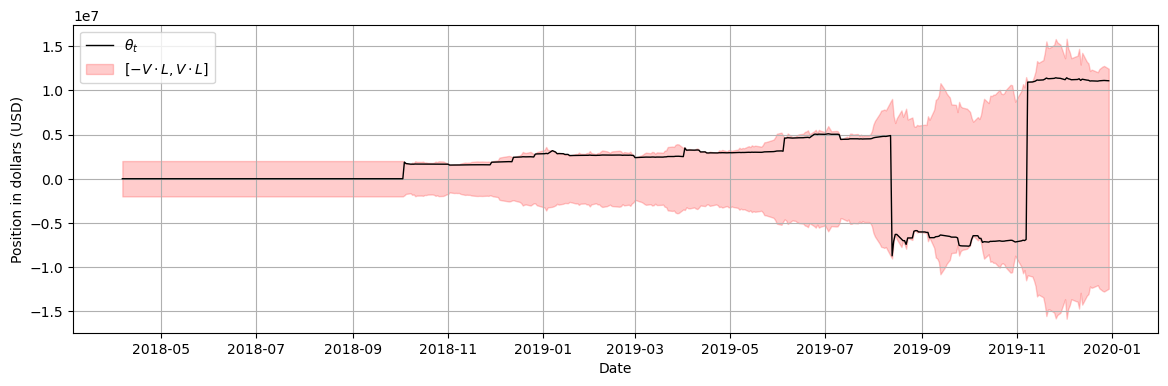

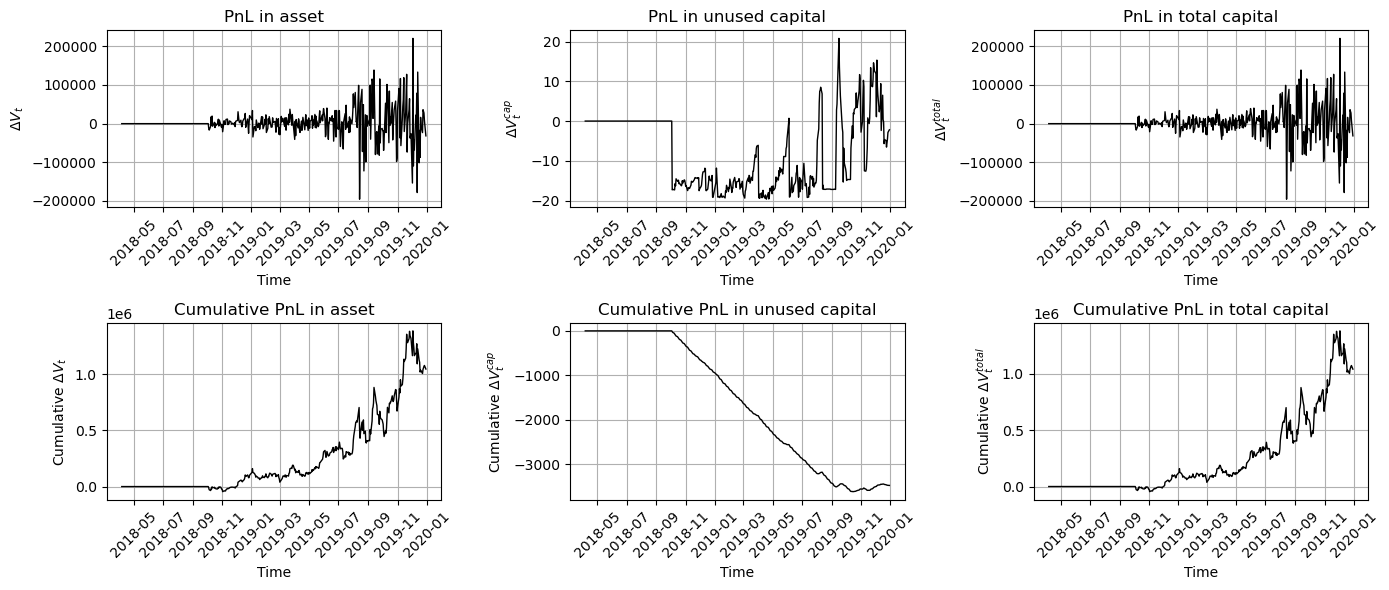

In [17]:
# Testing set performance
result_test = compute_position_value(df = test_set, 
                           signal = test_set['Signal'], 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0 = True)

plot_strategy(df = test_set, 
              result_dict = result_test, 
              signal = test_set['Signal'], 
              leverage = LEVERAGE)


/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:110: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


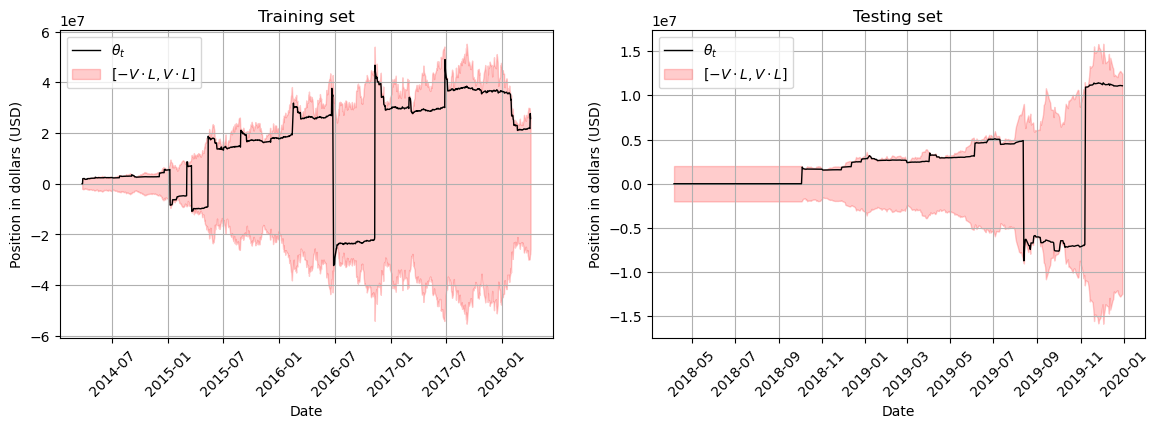

In [18]:
fig, ax = plot_position_compare(train_set_date = train_set['Date'], 
                      train_theta = result_train['theta'], 
                      train_V = result_train['V'], 
                      test_set_date = test_set['Date'], 
                      test_theta = result_test['theta'], 
                      test_V = result_test['V'], 
                      leverage = LEVERAGE)

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/trading_computation.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  turnover = [np.sum(np.abs(np.diff(theta[i:i+window_size] / price[i:i+window_size]))) for i in range(len(theta) - window_size + 1)]
/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:189: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Text(0.5, 1.0, 'LSTM rolling turnover in units')

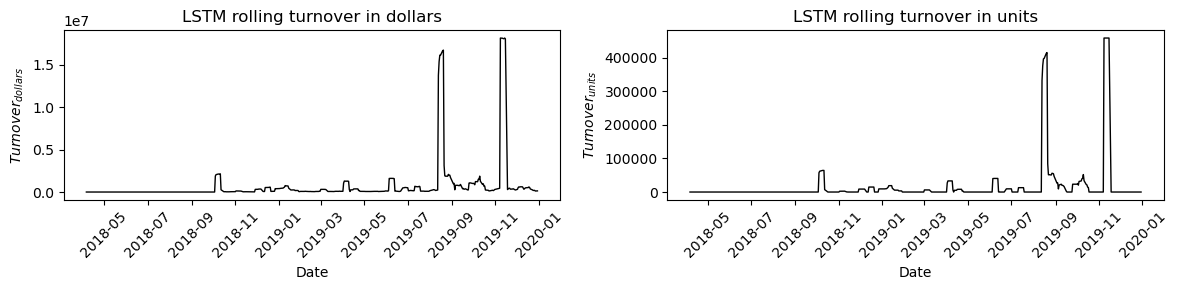

In [19]:
turnover_dollar = calculate_rolling_turnover(theta = result_test['theta'], 
                           price = test_set['Close'], 
                           mode = 'dollar')

turnover_unit = calculate_rolling_turnover(theta = result_test['theta'], 
                           price = test_set['Close'], 
                           mode = 'unit')

    
fig, ax = plot_turnover(test_set, turnover_dollar, turnover_unit, mode = 'Rolling')
ax[0].set_title('LSTM rolling turnover in dollars')
ax[1].set_title('LSTM rolling turnover in units')

In [20]:
df_train_res = pd.DataFrame(result_train)
df_train_res['Date'] = np.array(train_set['Date'])
df_train_res['Close'] = np.array(train_set['Close'])
df_train_res['Signal'] = np.array(train_set['Signal'])

df_test_res = pd.DataFrame(result_test)
df_test_res['Date'] = np.array(test_set['Date'])
df_test_res['Close'] = np.array(test_set['Close'])
df_test_res['Signal'] = np.array(test_set['Signal'])


if INCREASE_RF:
    df_train_res.to_csv('models_data/LSTM_TRAIN_RF.csv')
    df_test_res.to_csv('models_data/LSTM_TEST_RF.csv')
else:
    df_train_res.to_csv('models_data/LSTM_TRAIN.csv')
    df_test_res.to_csv('models_data/LSTM_TEST.csv')

## 3. Get average model performance

In [21]:
# cum_pnl = []
# cum_pnl_hold = []
# best_profit = -np.inf
# for iteration in range(5):
#     model = train_lstm(seed = iteration)
#     model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)
#     y_pred_test = model.predict(X_test)
#     y_pred_train = model.predict(X_train)
    
#     strategy_data.iloc[time_step: time_step+len(y_pred_train), strategy_data.columns.get_loc('Predictions')] = y_pred_train.flatten()
#     strategy_data.iloc[len(X_train)+time_step:len(X_train)+time_step+len(y_pred_test),strategy_data.columns.get_loc('Predictions')] = y_pred_test.flatten()
#     strategy_data['Buy_Signal_Price'], strategy_data['Sell_Signal_Price'] = buy_sell_threshold(strategy_data['Close'], strategy_data['Predictions'], 0.02)
#     buy_signal = np.where(strategy_data['Buy_Signal_Price'] > 0, 1, 0)
#     sell_signal = np.where(strategy_data['Sell_Signal_Price'] > 0, -1, 0)
#     signal = buy_signal + sell_signal
#     strategy_data['Signal'] = signal
#     result = compute_position_value(df = strategy_data, 
#                                 signal = strategy_data['Signal'], 
#                                 initial_capital = INITIAL_CAP, 
#                                 max_leverage = LEVERAGE, 
#                                 reduced_leverage_shorting = False,
#                                 hold_at_signal_0 = False)
    
#     result_hold = compute_position_value(df = strategy_data, 
#                             signal = strategy_data['Signal'], 
#                             initial_capital = INITIAL_CAP, 
#                             max_leverage = LEVERAGE, 
#                             reduced_leverage_shorting = False,
#                             hold_at_signal_0 = True)
    
#     pnl = np.cumsum(np.diff(result['Vtot']))[-1]
#     pnl_hold = np.cumsum(np.diff(result_hold['Vtot']))[-1]
#     cum_pnl.append(pnl)
#     cum_pnl_hold.append(pnl_hold)
    
#     # if pnl > best_profit:
#     #     best_profit = pnl
#     #     print(f'Model {iteration} achieves cumulative profit of {best_profit}')
#     #     model.save(f'models/lstm_iteration_{iteration}.h5')
        
#     # if pnl_hold > best_profit:
#     #     best_profit = pnl_hold
#     #     print(f'Model {iteration} achieves cumulative profit of {best_profit}')
#     #     model.save(f'models/lstm_iteration_{iteration}_hold.h5')
    
        
    

In [22]:
# print(f'Cumulative profit: {cum_pml}')
# print(f'Cumulative profit with reduced shorting leverage: {cum_pml_hold}')

In [23]:
# print(f'Mean cumulative profit: {np.mean(cum_pml):3f}')
# print(f'Mean cumulative profit with holding: {np.mean(cum_pml_hold):3f}')

In [24]:
# cum_pnl_hold